# Contrastive Loss

## Siamese Neural Networks

A popular approach for estimating sample similarity are **Siamese Neural Networks**.

They are made up of two (or more) Neural Networks which share identical weights.
If the embeddings produced for two different samples are similar, these two samples are considered to be similar (and vice versa).

## Contrastive Loss

The objective of Siamese Neural Networks is to maximize the distance between embeddings for dissimilar inputs while minimizing the distance between embeddings for similar ones.

A simple loss function for this objective is **Contrastive Loss**.

Contrastive loss is defined as follows:

$$L^m_\text{cont}(x_i, x_j; f) = \{y_i = y_j\} \cdot {||f_i - f_j||}_2^2 + \{y_i \neq y_j\} \cdot \text{max}(0, m - ||f_i - f_j||_2^2)$$

where $m$ is a margin parameter which imposes the distance between negative examples to be larger than $m$.

In practice the distance between the embeddings $f_i$ and $f_j$ is often computed as the euclidean or cosine distance.

Let's see if we can train our sign language detection model using Contrastive Loss.

Since our reason for using contrastive learning was to apply our model to previously unseen signs, let's exclude our test signs entirely from the trainign data.

For contrastive learning our data must be present in pairs of matching and non-matching samples:

Our labels now represent the distance between samples (0 if matching, 1 if non-matching).

In [1]:
from core.dataset import DGSAlphabet

TEST_LABELS = ['u', 'v', 'w', 'x', 'y']

# Import the dataset
dataset = DGSAlphabet()
pair_dataset = dataset.load_pairs(
    margin=1,
    exclusive_test_labels=TEST_LABELS
)

x_train_1 = pair_dataset.x_train_1
x_train_2 = pair_dataset.x_train_2
labels_train = pair_dataset.y_train


x_test_1 = pair_dataset.x_test_1
x_test_2 = pair_dataset.x_test_2
labels_test = pair_dataset.y_test

For our Siamese Neural Network we want to use the same original model's encoder, but twice with shared weights. We'll use the euclidean distance as our model's distance metric.

To give the model the best shot at success we'll use Keras Tuner once again.

In [2]:
from core.util import new_SNN_builder
from core.loss import new_contrastive_loss
from core.distance import euclidean_distance

# Create model builder for Keras Tuner
build_model = new_SNN_builder(
    mode="siamese",
    loss=new_contrastive_loss(margin=1),
    distance=euclidean_distance
)

/Users/moritz/Documents/Hochschule Augsburg/Semester 2 - Master/Data Science/project/venv/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
# Tuning Hyperparameters
# https://keras.io/api/keras_tuner/tuners/hyperband
MAX_EPOCHS = 150
FACTOR = 3
HYPERBAND_ITERATIONS = 1
SEED = 42
VAL_SPLIT = 0.2

# Where to save tuner checkpoints
TUNER_DIR = "tuner"
PROJECT = "contrastive_loss"

In [4]:
import keras_tuner

tuner = keras_tuner.Hyperband(
    hypermodel=build_model,
    objective="val_loss",
    max_epochs=MAX_EPOCHS,
    factor=FACTOR,
    hyperband_iterations=HYPERBAND_ITERATIONS,
    seed=SEED,
    directory=TUNER_DIR,
    project_name=PROJECT
)

tuner.search_space_summary()

Reloading Tuner from tuner/contrastive_loss/tuner0.json
Search space summary
Default search space size: 9
dense_count (Int)
{'default': None, 'conditions': [], 'min_value': 2, 'max_value': 10, 'step': 2, 'sampling': 'linear'}
dense_base (Int)
{'default': None, 'conditions': [], 'min_value': 8, 'max_value': 64, 'step': 8, 'sampling': 'linear'}
encoder_dropout (Boolean)
{'default': False, 'conditions': []}
siamese_bn (Boolean)
{'default': False, 'conditions': []}
siamese_dropout (Boolean)
{'default': False, 'conditions': []}
start_lr (Float)
{'default': 5e-05, 'conditions': [], 'min_value': 5e-05, 'max_value': 0.001, 'step': 5e-05, 'sampling': 'linear'}
beta_1 (Float)
{'default': 0.7, 'conditions': [], 'min_value': 0.7, 'max_value': 0.9, 'step': 0.1, 'sampling': 'linear'}
beta_2 (Float)
{'default': 0.99, 'conditions': [], 'min_value': 0.99, 'max_value': 0.999, 'step': 0.001, 'sampling': 'linear'}
epsilon (Float)
{'default': 0.001, 'conditions': [], 'min_value': 0.001, 'max_value': 0.01, 

In [5]:
from core.util import new_default_callbacks, TunerHistoryCallback

# Reduce learning rate if no improvement is made
reduce_lr, early_stop = new_default_callbacks(
    monitor="val_loss",
    mode="min",
    lr_reduce_factor=0.2,
    lr_reduce_patience=5,
    verbose=1
)

# Keep track of histories for every tuner trial
tuner_history_cb = TunerHistoryCallback(tuner)

Loading history from JSON tuner/contrastive_loss/history.json


An interesting experimental observation is that the contrastive model occasionally refuses to converge to any sort of optimum (= remains at random accuracy), especially when using larger learning rates.

In [6]:
tuner.search(
    [x_train_1, x_train_2], 
    labels_train,
    validation_split=VAL_SPLIT,
    callbacks=[reduce_lr, early_stop, tuner_history_cb]
)

In [7]:
tuner.results_summary()

Results summary
Results in tuner/contrastive_loss
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 0234 summary
Hyperparameters:
dense_count: 8
dense_base: 40
encoder_dropout: False
siamese_bn: True
siamese_dropout: False
start_lr: 0.0009000000000000001
beta_1: 0.7
beta_2: 0.994
epsilon: 0.001
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 0228
Score: 0.00955765601247549

Trial 0146 summary
Hyperparameters:
dense_count: 8
dense_base: 56
encoder_dropout: False
siamese_bn: True
siamese_dropout: False
start_lr: 0.0007000000000000001
beta_1: 0.7999999999999999
beta_2: 0.992
epsilon: 0.003
tuner/epochs: 150
tuner/initial_epoch: 50
tuner/bracket: 4
tuner/round: 4
tuner/trial_id: 0143
Score: 0.012066235765814781

Trial 0250 summary
Hyperparameters:
dense_count: 6
dense_base: 24
encoder_dropout: False
siamese_bn: False
siamese_dropout: True
start_lr: 0.00075
beta_1: 0.8999999999999999
beta_2: 0.997
epsilon: 0.004
tuner/epochs:

Since we want convenient access to the model's encoder part, we'll re-instantiate the model with the best architecture and transfer the best model's weights:

In [8]:
# Get history of best model training
best_trial = tuner.oracle.get_best_trials(1)[0]
best_model_history = tuner_history_cb.get_trial_history(
    best_trial.trial_id
)

# Get weights of best model
best_model = tuner.get_best_models(1)[0]
best_weights = best_model.weights

# Re-create best architecture
best_hyper_params = tuner.get_best_hyperparameters(1)[0]
snn_encoder, siamese_snn = build_model(best_hyper_params, get_encoder=True)
siamese_snn.set_weights(best_weights)

siamese_snn.summary()

Model: "SNN_8_siamese"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 input_4 (InputLayer)        [(None, 21, 3)]              0         []                            
                                                                                                  
 SNN_8_encoder (Functional)  (None, 40)                   1038384   ['input_3[0][0]',             
                                                          6          'input_4[0][0]']             
                                                                                                  
 lambda_1 (Lambda)           (None, 1)                    0         ['SNN_8_encoder[0]

Let's save the best model and take a look at its training history:

In [9]:
from pathlib import Path

MODEL_DIR = "models"
Path(MODEL_DIR).mkdir(parents=True, exist_ok=True)

siamese_snn.save(f"{MODEL_DIR}/contrastive_loss.keras")

Our model now takes about twice the number of epochs to converge (not least due to the reduced learning rate), but we seem to converge to decently low validation loss.

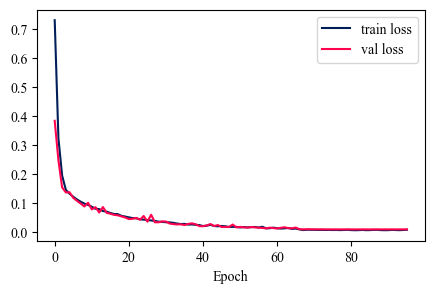

In [10]:
from core.viz import visualize_history

visualize_history( best_model_history, ["loss"])

Our model also seems to perform quite well on entirely new signs:

In [11]:
# And evaluate the model on test data
loss = siamese_snn.evaluate([x_test_1, x_test_2], labels_test, verbose=0)
print(f'++++++++++++ Test data ++++++++++++\nloss={loss:.4f}')

++++++++++++ Test data ++++++++++++
loss=0.1401


We can now also examine the model in terms of One-Shot classification.

In [12]:
categorical_dataset = dataset.load_categorical_numeric(
    exclusive_test_labels=TEST_LABELS
)

x_test = categorical_dataset.x_test
y_test = categorical_dataset.y_test
label_map = categorical_dataset.label_map

To do so we calculate a metric referred to as n-way accuracy.

We randomly choose $n$ samples of different classes as our support set. All other samples form the query set.
Each sample from the query set will be compared to every sample of the support set. The support set sample's embedding producing the smallest distance to the query sample's embedding will be chosen as a prediction.

To simplify things we set $n=5$, meaning our support set encompasses all classes from the test set.

Since the model's ability to predict correct classes might depend on the quality of the randomly chosen support samples, we perform multiple iterations of the same evaluation process where different support samples are chosen every time.

While obviously lower than with conventional classification, our accuracy score is still somewhat respectable:

In [13]:
from core.util import evaluate_n_way_accuracy


y_true, y_pred, mean_acc, min_acc, max_acc, std = evaluate_n_way_accuracy(
    x_test,
    y_test,
    snn_encoder,
    k_prototype=1,
    iterations=10
)

print(
    f"Mean 5-way accuracy: {mean_acc}\n"
    f"Min 5-way accuracy: {min_acc}\n"
    f"Max 5-way accuracy: {max_acc}\n"
    f"5-way accuracy std.: {std}"
)

50/50 [==============================] - 0s 6ms/step
Mean 5-way accuracy: 0.7586075949367089
Min 5-way accuracy: 0.6727848101265823
Max 5-way accuracy: 0.8588607594936709
5-way accuracy std.: 0.06545307564477287


Another way to potentially improve our model's One-Shot performance is to use prototypes in our support set.

Instead of comparing against a single random support embedding, we'll average $k$ random embeddings to form a support prototype.
This could potentially help reduce the negative effects from outliers being chosen as supports.

As we can see, prototypes significantly improve the accuracy score and reduce the accuracy variance across iterations. However, there seems to be a sweet-spot at $k=10$, after which the n-way accuracy seems to stagnate:

In [14]:
k_prototype = [1, 3, 5, 10, 15, 20, 50, 75, 100]

for k in k_prototype:
    _, _, n_way_acc_pk, _, _, std = evaluate_n_way_accuracy(
        x_test,
        y_test,
        snn_encoder,
        k_prototype=k,
        iterations=10
    )

    print(
        f"Mean 5-way accuracy (k-prototype = {k}): {n_way_acc_pk}, std: {std}"
    )

50/50 [==============================] - 0s 6ms/step
Mean 5-way accuracy (k-prototype = 1): 0.7586075949367089, std: 0.06545307564477287
50/50 [==============================] - 0s 6ms/step
Mean 5-way accuracy (k-prototype = 3): 0.8011464968152866, std: 0.05648485788196733
50/50 [==============================] - 0s 6ms/step
Mean 5-way accuracy (k-prototype = 5): 0.8339743589743589, std: 0.03644950935764275
50/50 [==============================] - 0s 6ms/step
Mean 5-way accuracy (k-prototype = 10): 0.842671009771987, std: 0.008928884802675917
50/50 [==============================] - 0s 5ms/step
Mean 5-way accuracy (k-prototype = 15): 0.8373509933774834, std: 0.007470245643551562
50/50 [==============================] - 0s 5ms/step
Mean 5-way accuracy (k-prototype = 20): 0.8386531986531987, std: 0.007365661367744277
50/50 [==============================] - 0s 5ms/step
Mean 5-way accuracy (k-prototype = 50): 0.8358052434456928, std: 0.007237676302131024
50/50 [===========================

Looking at the confusion matrix, we can see a worrying pattern:
The model performs very well on "easy" pairings while it is little better than random for "hard" pairings ("easy" as in: solved well by the original classification model which was trained on the entire dataset; "hard": analogous).

Improving the model's ability to distinguish similar (hard) samples is a central problem of contrastive learning.

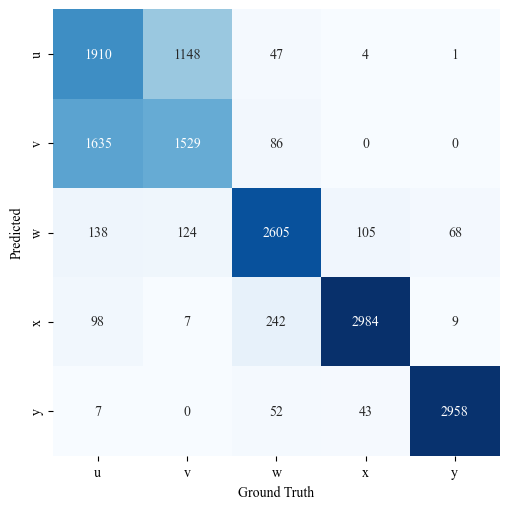

In [15]:
from core.viz import visualize_confusion_matrix

unique_test_labels = list(set(y_test))
reverse_label_map = {int_lbl: str_lbl for str_lbl, int_lbl in label_map.items()}
str_test_labels = [reverse_label_map[lbl] for lbl in unique_test_labels]

visualize_confusion_matrix(y_true, y_pred, str_test_labels)

Finally, we can take a look at the embeddings our contrastive model produces.

In [16]:
# And get embeddings for the test data
embeddings = snn_encoder.predict(x_test)

50/50 [==============================] - 0s 6ms/step


In [17]:
from sklearn.manifold import TSNE

# Fit T-SNE on embeddings
tsne = TSNE(n_components=2, random_state=42, verbose=1)
reduced_embeddings = tsne.fit_transform(embeddings)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 1585 samples in 0.000s...
[t-SNE] Computed neighbors for 1585 samples in 0.320s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1585
[t-SNE] Computed conditional probabilities for sample 1585 / 1585
[t-SNE] Mean sigma: 2.781180
[t-SNE] KL divergence after 250 iterations with early exaggeration: 54.419399
[t-SNE] KL divergence after 1000 iterations: 0.388061


Again, the weaknesses shown in the confusion matrix are repeated in the embeddings.

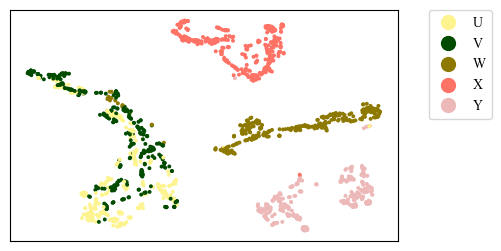

In [18]:
from core.viz import visualize_embeddings

# Visualize embeddings in scatter plot
visualize_embeddings(
    reduced_embeddings,
    y_test,
    label_map
)